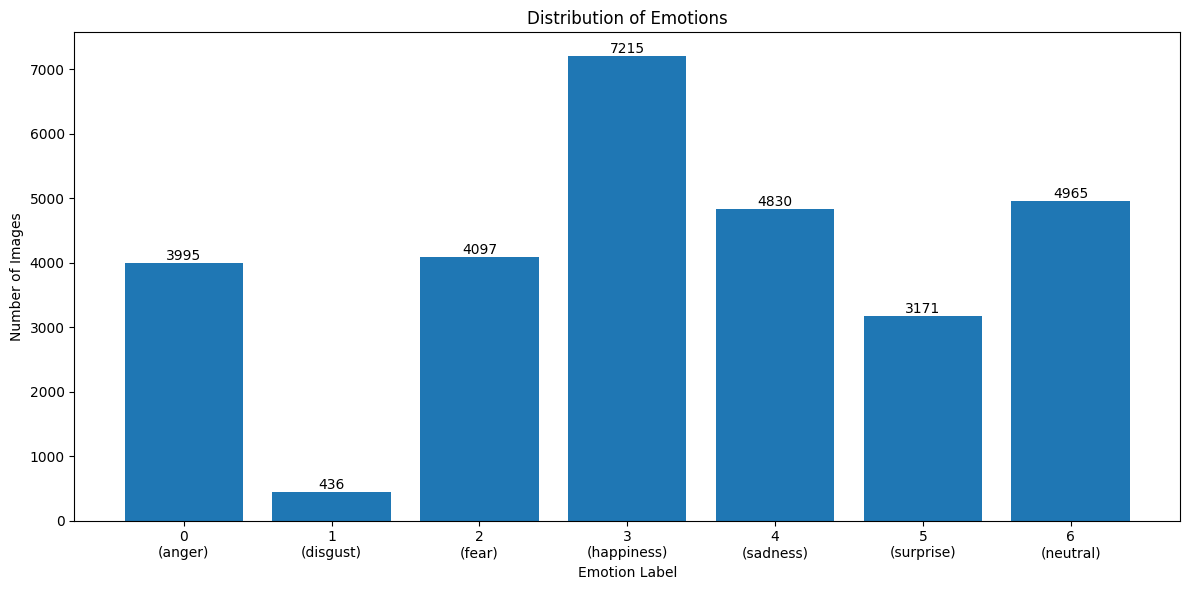

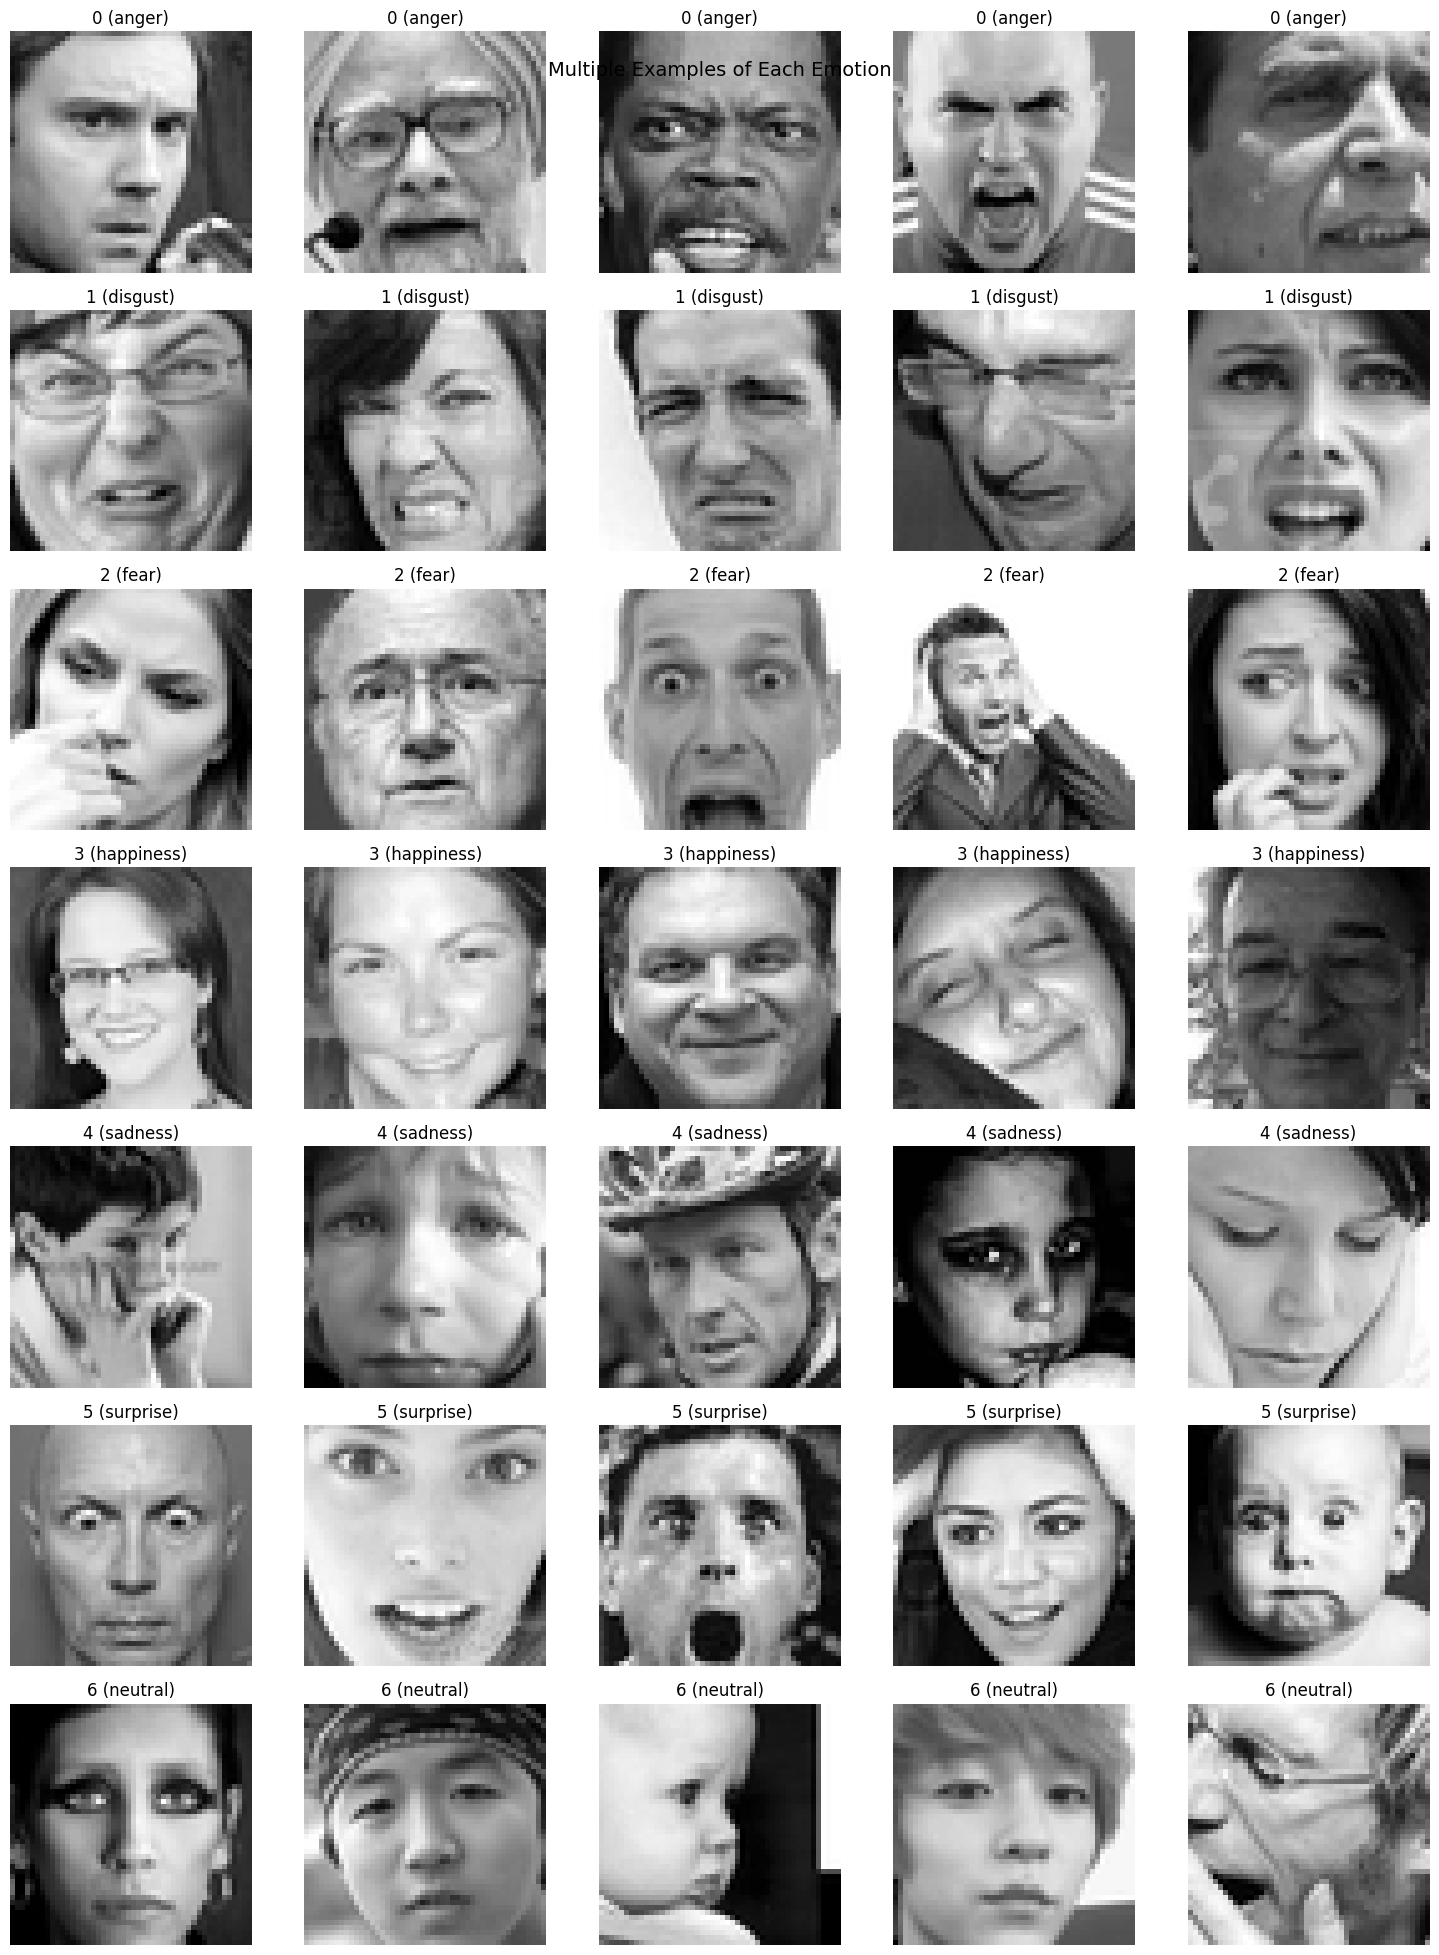

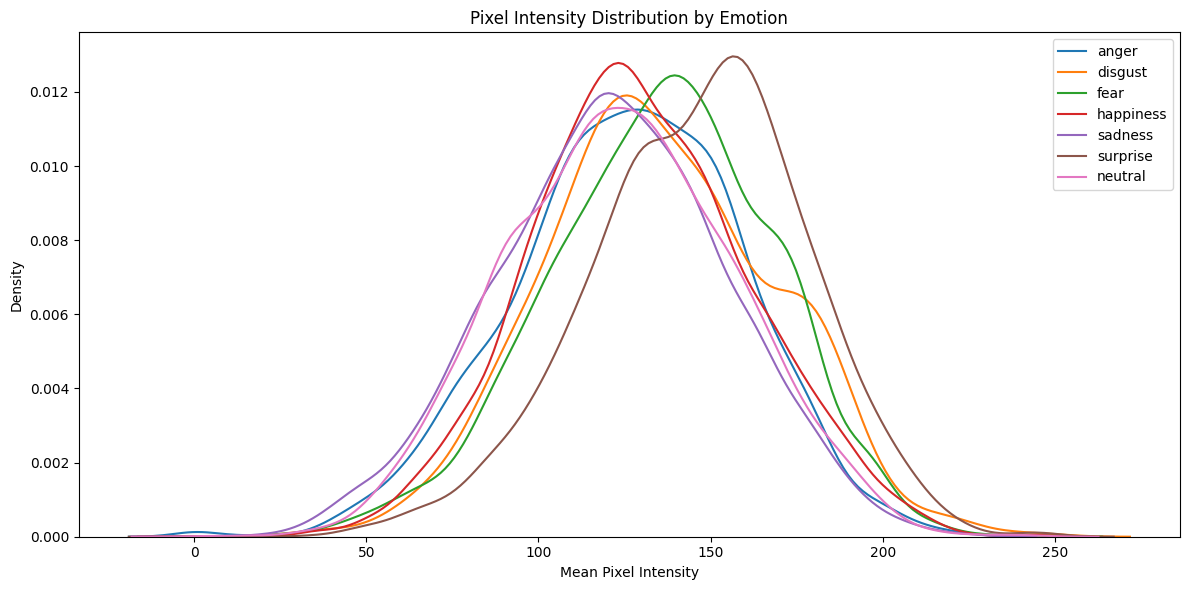

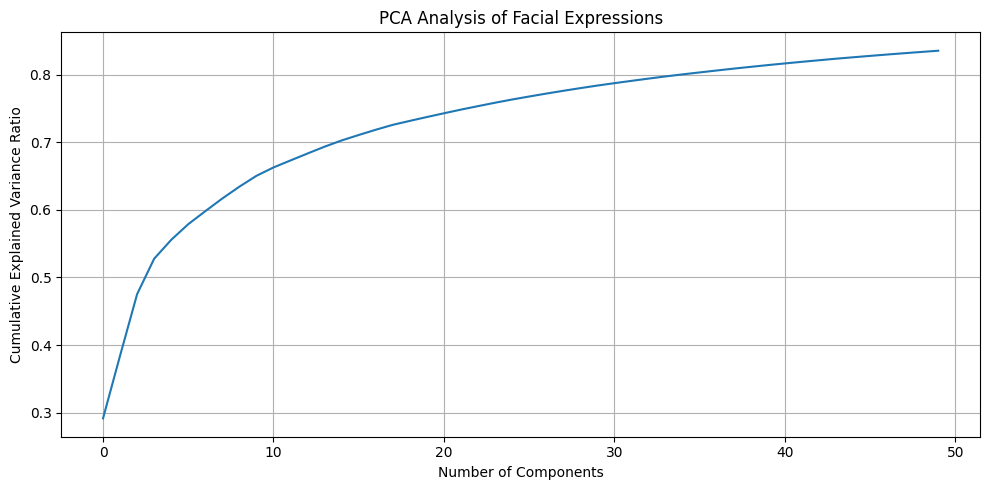


Dataset Statistics:
Total images: 28709

Images per emotion:
anger: 3995 (13.9%)
disgust: 436 (1.5%)
fear: 4097 (14.3%)
happiness: 7215 (25.1%)
sadness: 4830 (16.8%)
surprise: 3171 (11.0%)
neutral: 4965 (17.3%)

Pixel value range: [0, 255]
Image dimensions: 48x48


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the emotion mappings for FER original labels
EMOTIONS = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

# Read the data
df = pd.read_csv('train.csv')

# Function to convert pixel string to array
def pixels_to_array(pixels_str):
    pixels = [int(pixel) for pixel in pixels_str.split()]
    return np.array(pixels).reshape(48, 48)

# 1. Distribution plot
emotion_counts = df['emotion'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(EMOTIONS)), [emotion_counts[i] for i in range(len(EMOTIONS))])
plt.title('Distribution of Emotions')
plt.xlabel('Emotion Label')
plt.ylabel('Number of Images')
plt.xticks(range(len(EMOTIONS)), [f"{i}\n({EMOTIONS[i]})" for i in range(len(EMOTIONS))])

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')
plt.tight_layout()
plt.show()

# 2. Sample images
num_examples = 5
plt.figure(figsize=(15, 20))
for emotion_id in range(len(EMOTIONS)):
    emotion_samples = df[df['emotion'] == emotion_id].head(num_examples)
    
    for j, (_, sample_img) in enumerate(emotion_samples.iterrows()):
        img_array = pixels_to_array(sample_img['pixels'])
        
        plt.subplot(len(EMOTIONS), num_examples, emotion_id * num_examples + j + 1)
        plt.imshow(img_array, cmap='gray')
        plt.title(f"{emotion_id} ({EMOTIONS[emotion_id]})")
        plt.axis('off')
plt.suptitle('Multiple Examples of Each Emotion', size=14, y=0.95)
plt.tight_layout()
plt.show()

# 3. Pixel intensity analysis
plt.figure(figsize=(12, 6))
for emotion_id in EMOTIONS:
    emotion_data = df[df['emotion'] == emotion_id]
    pixel_means = emotion_data['pixels'].apply(
        lambda x: np.mean([int(p) for p in x.split()])
    )
    sns.kdeplot(pixel_means, label=EMOTIONS[emotion_id])
plt.title('Pixel Intensity Distribution by Emotion')
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# 4. PCA Analysis
# Prepare data for PCA
X = np.vstack(df['pixels'].apply(
    lambda x: np.array([int(p) for p in x.split()])
))

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
n_components = 50
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Analysis of Facial Expressions')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Print dataset statistics
print("\nDataset Statistics:")
print(f"Total images: {len(df)}")
print("\nImages per emotion:")
for emotion_id, count in emotion_counts.items():
    print(f"{EMOTIONS[emotion_id]}: {count} ({count/len(df)*100:.1f}%)")

pixel_min = df['pixels'].apply(lambda x: min(map(int, x.split()))).min()
pixel_max = df['pixels'].apply(lambda x: max(map(int, x.split()))).max()
print(f"\nPixel value range: [{pixel_min}, {pixel_max}]")
print(f"Image dimensions: 48x48")

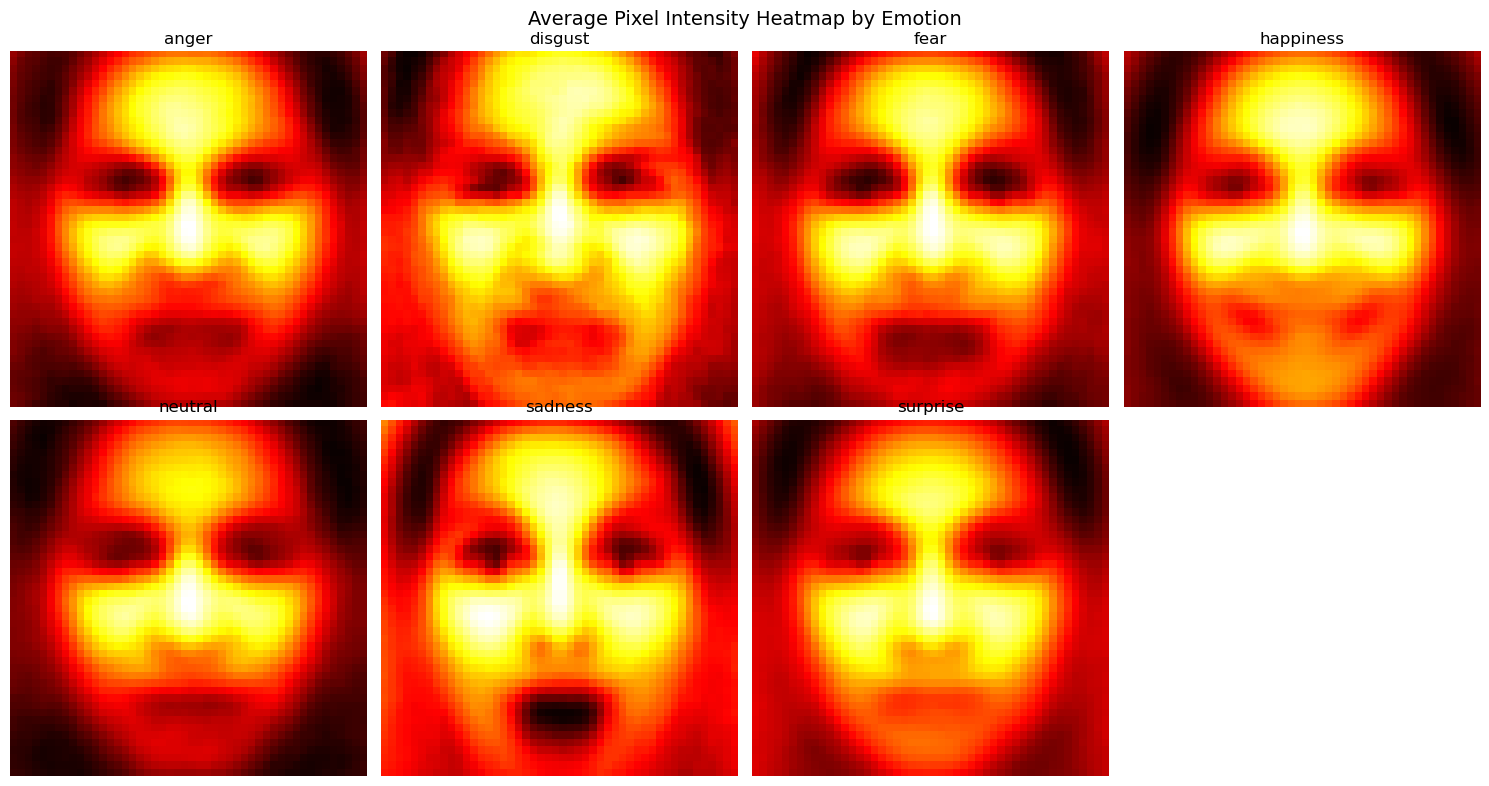

In [104]:
plt.figure(figsize=(15, 8))
for emotion_id, emotion_name in EMOTIONS.items():
    emotion_data = df[df['emotion'] == emotion_id]['pixels']
    avg_image = np.mean([pixels_to_array(p) for p in emotion_data], axis=0)
    
    plt.subplot(2, 4, emotion_id + 1)
    plt.imshow(avg_image, cmap='hot')
    plt.title(f"{emotion_name}")
    plt.axis('off')
plt.suptitle('Average Pixel Intensity Heatmap by Emotion', size=14)
plt.tight_layout()
plt.show()


/var/folders/2x/bkq1mkv17gl5zjsg4by8zgyr0000gn/T/ipykernel_30040/288711188.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='emotion', y='symmetry', palette='viridis')


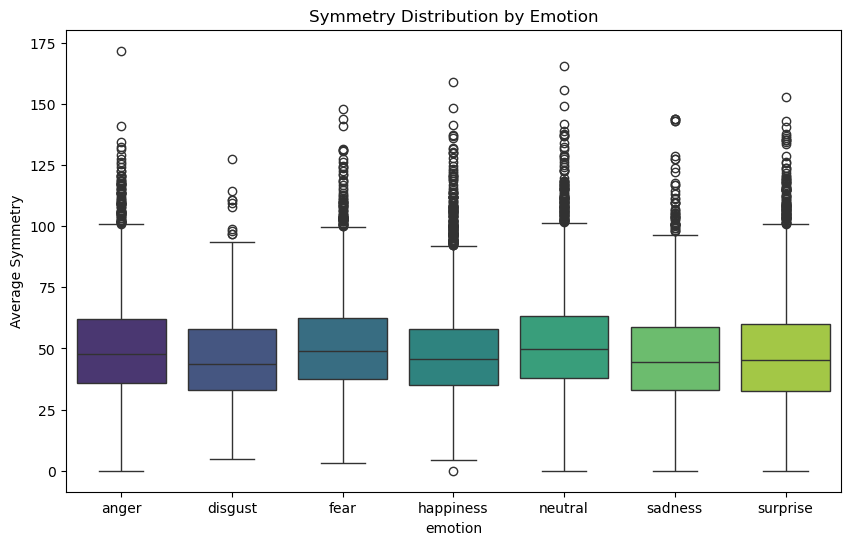

In [106]:
def calculate_symmetry(pixels):
    img_array = pixels_to_array(pixels)
    left_half = img_array[:, :24]
    right_half = np.fliplr(img_array[:, 24:])
    symmetry = np.sum(np.abs(left_half - right_half)) / (24 * 48)  # Average difference
    return symmetry

df['symmetry'] = df['pixels'].apply(calculate_symmetry)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='emotion', y='symmetry', palette='viridis')
plt.xticks(range(len(EMOTIONS)), [EMOTIONS[i] for i in range(len(EMOTIONS))])
plt.title("Symmetry Distribution by Emotion")
plt.ylabel("Average Symmetry")
plt.show()


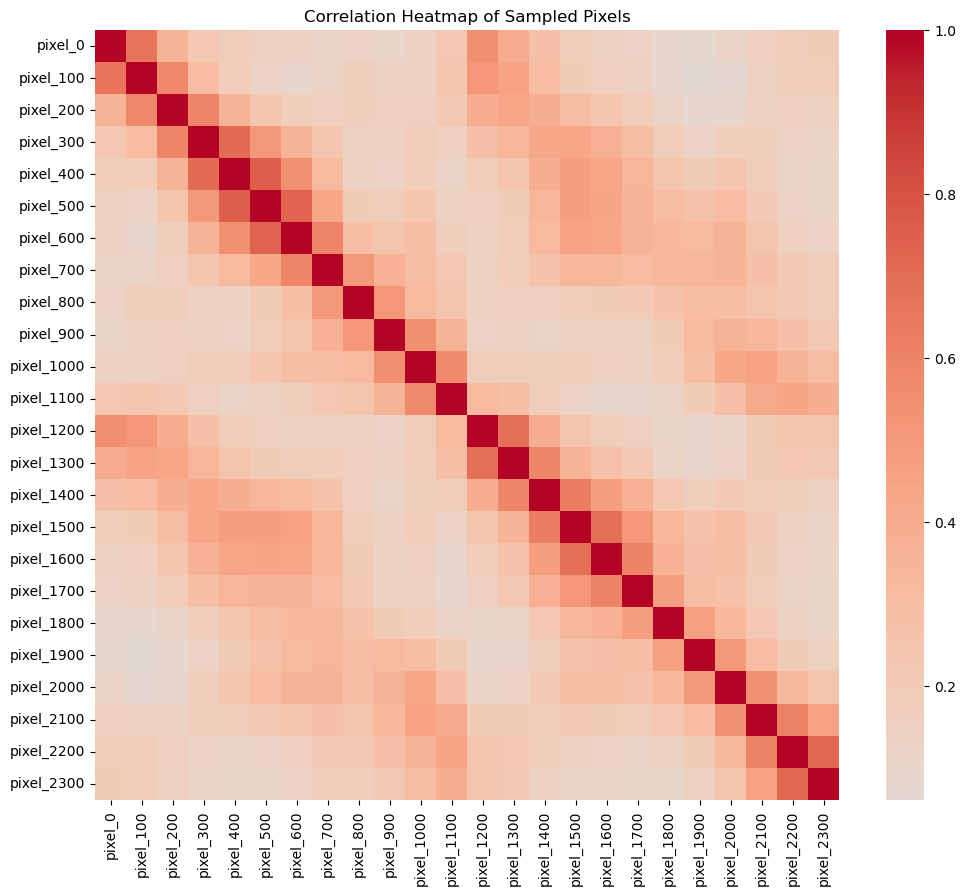

In [108]:
sample_pixels = [i for i in range(0, 2304, 100)]  # Select sample pixel indices
pixel_data = pd.DataFrame(X[:, sample_pixels], columns=[f'pixel_{i}' for i in sample_pixels])
pixel_corr = pixel_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(pixel_corr, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Heatmap of Sampled Pixels")
plt.show()


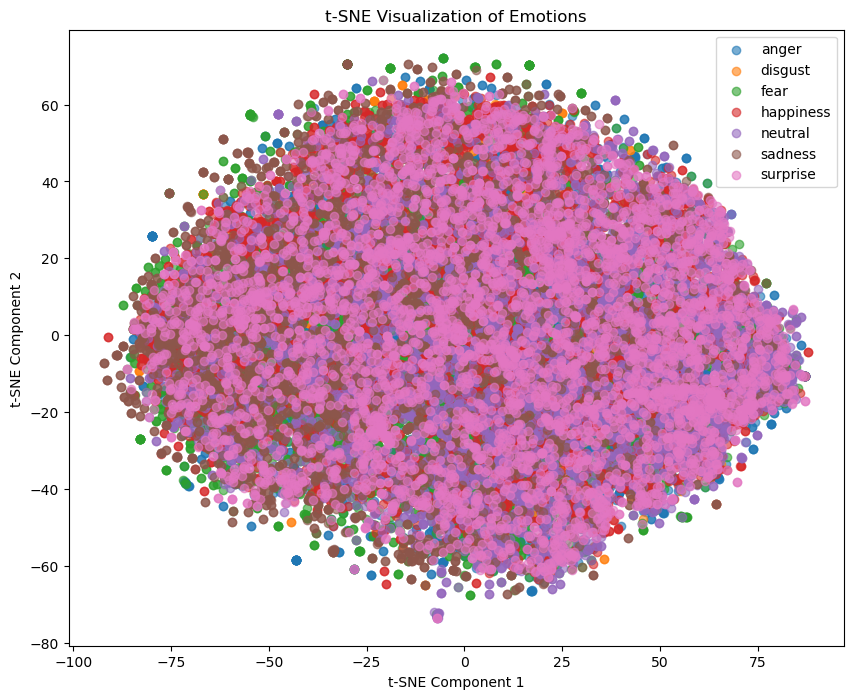

In [116]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
for emotion_id, emotion_name in EMOTIONS.items():
    plt.scatter(X_tsne[df['emotion'] == emotion_id, 0],
                X_tsne[df['emotion'] == emotion_id, 1],
                label=emotion_name, alpha=0.6)
plt.legend()
plt.title("t-SNE Visualization of Emotions")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


/var/folders/2x/bkq1mkv17gl5zjsg4by8zgyr0000gn/T/ipykernel_30040/1690938459.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='emotion', y='top_intensity', palette='cool')


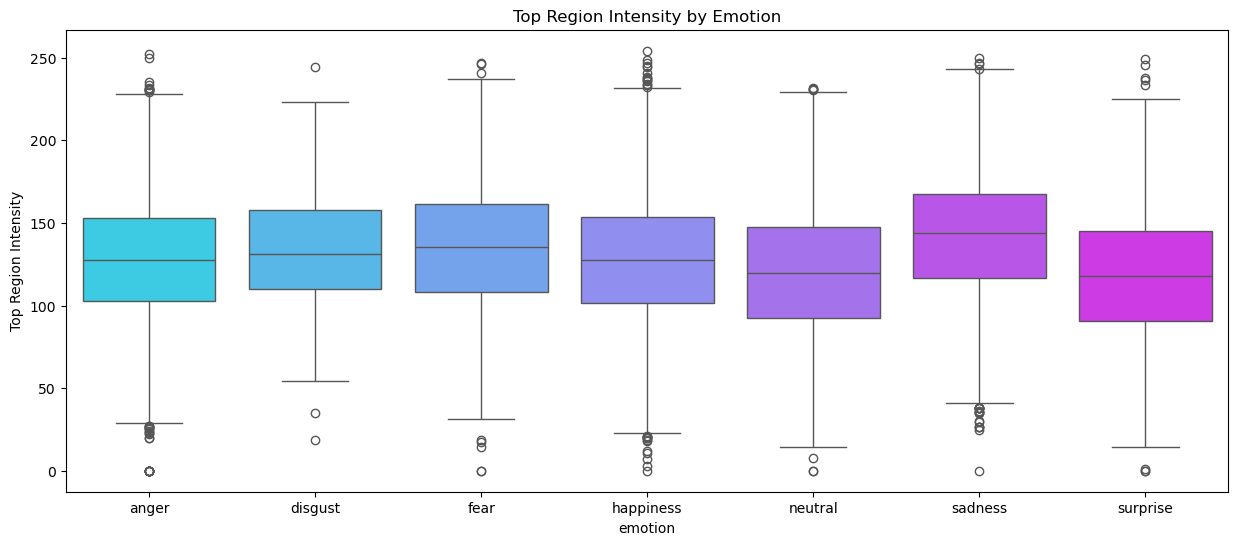

In [117]:
def region_intensity(pixels_str, region):
    img = pixels_to_array(pixels_str)
    if region == 'top':
        return np.mean(img[:16, :])
    elif region == 'middle':
        return np.mean(img[16:32, :])
    elif region == 'bottom':
        return np.mean(img[32:, :])

for region in ['top', 'middle', 'bottom']:
    df[f'{region}_intensity'] = df['pixels'].apply(lambda x: region_intensity(x, region))

plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='emotion', y='top_intensity', palette='cool')
plt.title("Top Region Intensity by Emotion")
plt.xticks(range(len(EMOTIONS)), [EMOTIONS[i] for i in range(len(EMOTIONS))])
plt.ylabel("Top Region Intensity")
plt.show()
